# Part 1: Logistic Regression (From Scratch vs. Keras)

In [20]:
# A few bits of code were adapted from 
# https://github.com/beckernick/logistic_regression_from_scratch/blob/master/logistic_regression_scratch.ipynb

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Generate data from two slightly overlapping 2D gaussian distributions.
np.random.seed(1)
nsamples = 500

x0 = np.random.multivariate_normal([0, 0], [[1, .75], [.75, 1]], nsamples)
x1 = np.random.multivariate_normal([1, 3], [[1, .75], [.75, 1]], nsamples)
X = np.vstack((x0, x1)).astype(np.float32)
means = np.mean(X, axis=0)
X = X - means

# The first group has a label of 0, the second 1.
y = np.hstack((np.zeros(nsamples),
               np.ones(nsamples)))

def plot_data(X, y, title=''):
    plt.figure(figsize=(10, 6))
    plt.title(title)
    plt.scatter(X[:, 0], X[:, 1],
                c = y, alpha = 0.2, cmap='rainbow')

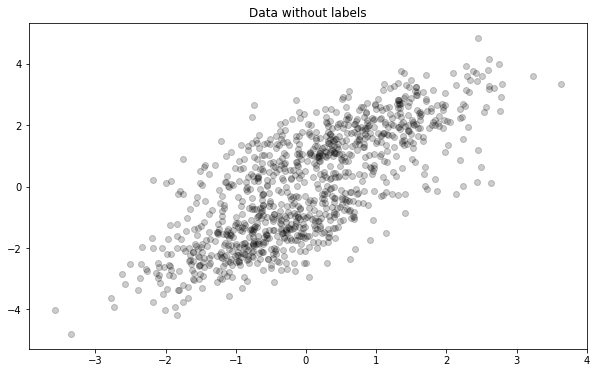

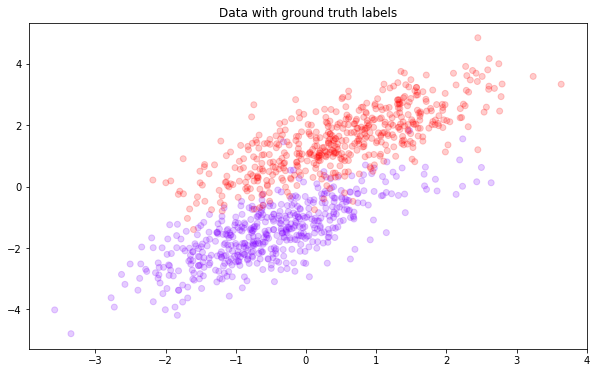

In [37]:
# Visualize X
plt.figure(figsize=(10, 6))
plt.title('Data without labels')
plt.scatter(X[:, 0], X[:, 1],
            c = 'black', alpha = 0.2)

# Visualize X and y
plot_data(X, y, 'Data with ground truth labels')

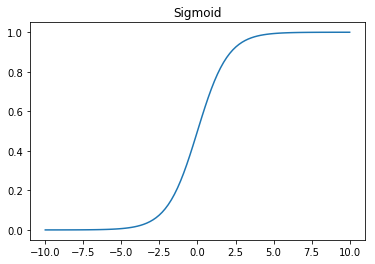

In [38]:
# The sigmoid activation function maps to probabilities.
def sigmoid(scores):
    return 1 / (1 + np.exp(-scores))

x_sig = np.linspace(-10, 10, 100)
y_sig = sigmoid(x_sig)
plt.title('Sigmoid')
plt.plot(x_sig, y_sig)
plt.show()

![](img/slp.gif)
Figure from http://rfhs8012.fh-regensburg.de/~saj39122/jfroehl/diplom/e-12-text.html

In [23]:
# Predict the value of y given input X and weights w.
# For each sample, the output is sigmoid(X0 * w0 + X0 * w1)
def predict(X, w):
    kernel = np.dot(X, w)
    return sigmoid(kernel)

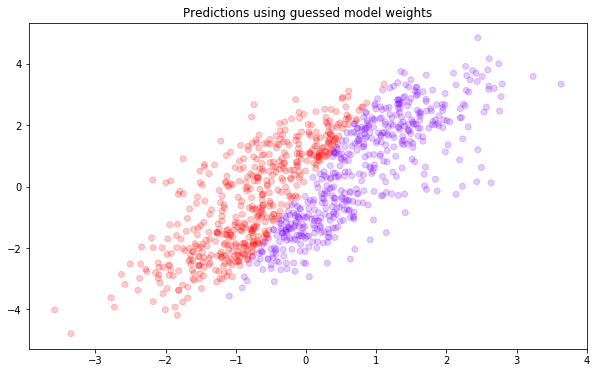

In [116]:
# Guess the weights.
w = np.array([-3., 1.])
y_probs = predict(X, w)

# If prob > 0.5, then classify as 1
y_preds = np.round(y_probs)
plot_data(X, y_preds, 'Predictions using guessed model weights')

In [129]:
# The loss function measures how bad the predictions of the model are.
# The lower this number, the better.
def loss(X, w, y):
    kernel = np.dot(X, w)
    # Compute the negative log likelihood of the data under the model.
    return -np.sum(y * kernel - np.log(1 + np.exp(kernel)))

# The gradient of the loss points the way to a better model with lower loss.
# This is the gradient (from multivariable calculus) of the loss with respect to the 
# weights.
def gradient_loss(X, w, y):
    y_preds = predict(X, w)
    error = (y - y_preds)[:, np.newaxis]
    return np.dot(X.T, error)[:, 0]

In [170]:
nsamples = 20
wmin = -7
wmax = 7

mx, my = np.meshgrid(np.linspace(wmin, wmax, nsamples), np.linspace(wmin, wmax, nsamples))
losses = np.zeros(mx.shape)
grads0 = np.zeros(mx.shape)
grads1 = np.zeros(mx.shape)

for i in range(mx.shape[0]):
    for j in range(mx.shape[1]):
        weight = np.array([mx[i, j], my[i, j]])
        grad = gradient_loss(X, weight, y)
        # Normalize grad to unit length
        grad /= np.linalg.norm(grad)
        losses[i, j] = loss(X, weight, y)
        grads0[i, j] = grad[0]
        grads1[i, j] = grad[1]

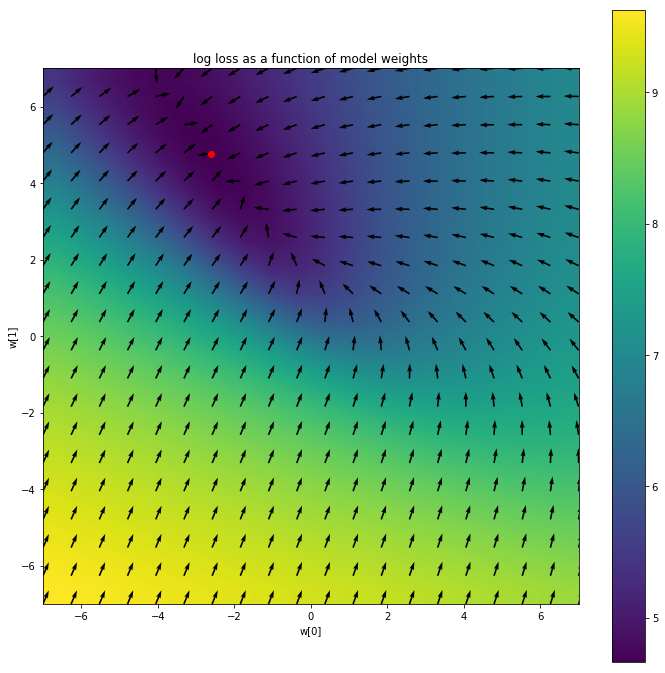

In [185]:
plt.figure(figsize=(12, 12))
plt.imshow(np.flipud(np.log(losses)), interpolation='bilinear', extent=(wmin, wmax, wmin, wmax))
plt.colorbar()
plt.quiver(mx, my, grads0, grads1)
plt.scatter([-2.60928453], [4.75528667], color='red')
plt.xlabel('w[0]')
plt.ylabel('w[1]')
plt.title('log loss as a function of model weights')

In [124]:
# The gradient descent algorithm for optimizing the weights.
# At each step, move the weights in the direction of the
# gradient of the loss function.
def optimize_weights(w, learning_rate, steps):
    losses = []
    for s in range(steps):
        grad_loss = gradient_loss(X, w, y)
        w += learning_rate * grad_loss
        losses.append(loss(X, w, y))
    return w, losses

In [125]:
init_w = np.array([0., 0.])
# Depending on the learning rate, you can either converge slowly, 
# converge quickly, chatter, or fluctuate wildly.
# 0.0005, 0.005, 0.1, 0.5
learning_rate = 0.005
steps = 100
w, losses = optimize_weights(init_w, learning_rate, steps)

[-2.60928453  4.75528667]


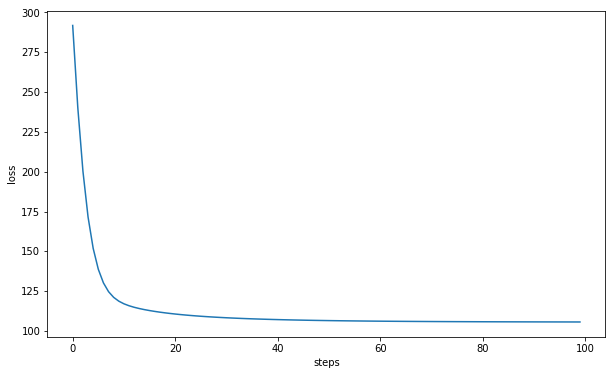

In [43]:
print(w)

plt.figure(figsize=(10, 6))
plt.xlabel('steps')
plt.ylabel('loss')
plt.plot(range(0,steps), losses)

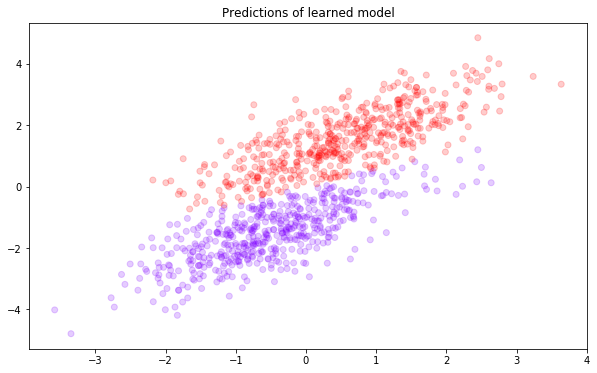

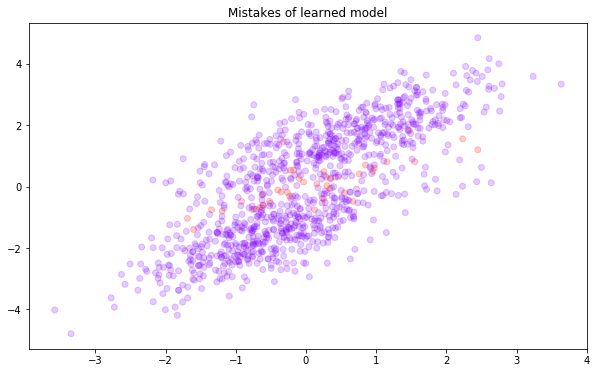

In [28]:
# Plot predictions of optimized model.
y_probs = predict(X, w)
y_preds = np.round(y_probs)

plot_data(X, y_preds, 'Predictions of learned model')

# Highlight mistakes
plot_data(X, y_preds != y, 'Mistakes of learned model')

In [32]:
# Reimplement logistic regression using Keras
from keras.models import Sequential
from keras.layers import Dense, Input

# We want to measure how the model does on new data it hasn't seen during training.
# Therefore, we split it into training and validation sets that have 80% and 20% of the
# data respectively.
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2)

# Create the Keras model. This is equivalent to the predict function above.
# Layers are objects that represent functions along with associated weight arrays.
# A Dense layer just computes a linear function of the inputs.
input_shape = (2,)
model = Sequential()
model.add(Dense(1, activation='sigmoid', input_shape=input_shape))

# Compile the model and then optimize/fit the parameters using 
# stochastic gradient descent (SGD). SGD is the same as optimize_weights
# except that it computes the gradient using a minibatch of data at each step
# which is a small fraction of the dataset. Due to this, it is a stochastic 
# approximation of the true gradient over the entire dataset. Keras computes the 
# gradient automatically and can do the processing on the GPU for a 30x speedup 
# on big models.
model.compile(optimizer='sgd', loss='binary_crossentropy')
model.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val))

Train on 800 samples, validate on 200 samples
Epoch 1/100
800/800 [==============================] - 0s - loss: 0.2634 - val_loss: 0.2628
Epoch 2/100
800/800 [==============================] - 0s - loss: 0.2529 - val_loss: 0.2528
Epoch 3/100
800/800 [==============================] - 0s - loss: 0.2442 - val_loss: 0.2443
Epoch 4/100
800/800 [==============================] - 0s - loss: 0.2368 - val_loss: 0.2370
Epoch 5/100
800/800 [==============================] - 0s - loss: 0.2305 - val_loss: 0.2307
Epoch 6/100
800/800 [==============================] - 0s - loss: 0.2250 - val_loss: 0.2251
Epoch 7/100
800/800 [==============================] - 0s - loss: 0.2202 - val_loss: 0.2202
Epoch 8/100
800/800 [==============================] - 0s - loss: 0.2159 - val_loss: 0.2158
Epoch 9/100
800/800 [==============================] - 0s - loss: 0.2121 - val_loss: 0.2118
Epoch 10/100
800/800 [==============================] - 0s - loss: 0.2087 - val_loss: 0.2081
Epoch 11/100
800/800 [===========

800/800 [==============================] - 0s - loss: 0.1451 - val_loss: 0.1357
Epoch 89/100
800/800 [==============================] - 0s - loss: 0.1448 - val_loss: 0.1354
Epoch 90/100
800/800 [==============================] - 0s - loss: 0.1445 - val_loss: 0.1350
Epoch 91/100
800/800 [==============================] - 0s - loss: 0.1443 - val_loss: 0.1347
Epoch 92/100
800/800 [==============================] - 0s - loss: 0.1440 - val_loss: 0.1344
Epoch 93/100
800/800 [==============================] - 0s - loss: 0.1437 - val_loss: 0.1341
Epoch 94/100
800/800 [==============================] - 0s - loss: 0.1435 - val_loss: 0.1337
Epoch 95/100
800/800 [==============================] - 0s - loss: 0.1432 - val_loss: 0.1334
Epoch 96/100
800/800 [==============================] - 0s - loss: 0.1429 - val_loss: 0.1331
Epoch 97/100
800/800 [==============================] - 0s - loss: 0.1427 - val_loss: 0.1328
Epoch 98/100
800/800 [==============================] - 0s - loss: 0.1424 - val_los

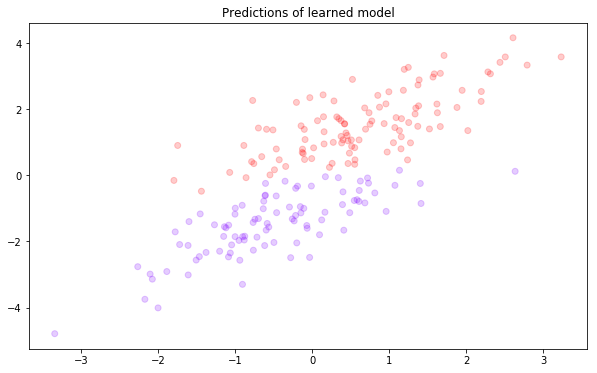

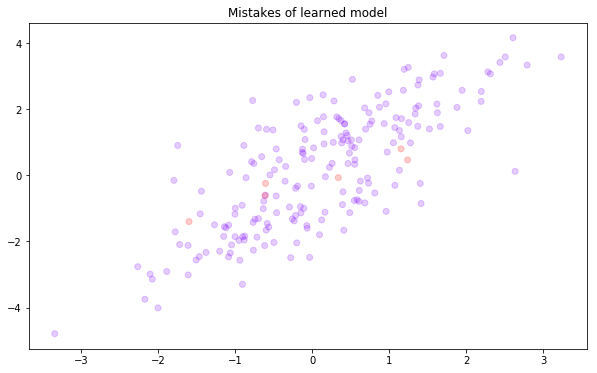

In [33]:
# Plot predictions of Keras model.
y_val_preds = np.round(model.predict(X_val)[:, 0])
plot_data(X_val, y_val_preds, 'Predictions of learned model')

# Highlight mistakes.
plot_data(X_val, y_val_preds != y_val, 'Mistakes of learned model')